<h1>COMP 6721 Applied Artificial Intelligence</h1>

In [263]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix , classification_report

In [221]:
dataSet_Path = 'Project_Dataset/'
learning_rate = 0.01
epochs = 10
use_saved_model = False

In [222]:
def data_loader(path,batch,test_data_index,validation_data_index):

    torch.manual_seed(0)
    transformer = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.225, 0.225, 0.225])])

    all_data = ImageFolder(root=path, transform=transformer)

    data_test_size = math.floor(test_data_index*len(all_data))
    data_train_size =  len(all_data) - data_test_size
    data_validation_size = math.floor(validation_data_index * data_train_size)
    data_train_size = data_train_size - data_validation_size

    print("Length of Total Data Set : " ,len(all_data) )
    print("Length of Training Data Set :  ", data_train_size )
    print("Length of Validation Data Set :  ", data_validation_size)
    print("Length of Test Data Set :  ", data_test_size)

    data_train_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[:data_train_size])
    data_validation_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[data_train_size:data_train_size+data_validation_size])
    data_test_loader = DataLoader(all_data,batch_size=batch,pin_memory=True,sampler=torch.randperm(len(all_data))[(data_train_size+data_validation_size):])

    # print(len(data_train_loader.dataset))
    # print(len(data_validation_loader.dataset))
    # print(len(data_test_loader.dataset))

    labels = 'Training', 'Validation', 'Testing'
    sizes = [data_train_size, data_validation_size, data_test_size]
    explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

    return data_train_loader, data_validation_loader ,data_test_loader


Length of Total Data Set :  2808
Length of Training Data Set :   1798
Length of Validation Data Set :   449
Length of Test Data Set :   561


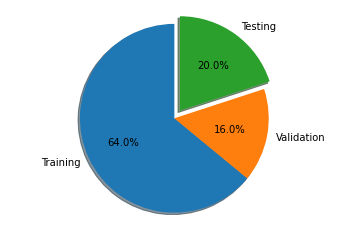

In [223]:
data_train_loader, data_validation_loader ,data_test_loader = data_loader(dataSet_Path,32,0.2,0.2)

In [224]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers =  nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            # nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            # nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            # nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            nn.MaxPool2d(2,2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*16*16,50),
            nn.Linear(50,5)

        )

    def forward(self,X):
        X = self.convlayers(X)
        X =  self.FC(X.reshape(-1,128*16*16))
        return X

In [225]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [226]:
model = CNN().to(device)

if use_saved_model:
    model.load_state_dict(torch.load("CNN.model"),strict=False)

In [227]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [228]:
complete_training_loss_list = []
complete_validation_loss_list = []
accuracy_list = []

if not use_saved_model:

    for e in tqdm_notebook(range(epochs) , desc = "Epochs Completed : "):
        model.train()
        loss_training = 0
        for i, (images,labels) in enumerate(data_train_loader):
            outputs = model(images.to(device))
            model.zero_grad()
            loss_training = criterion(outputs,labels.to(device))
            loss_training.backward()
            optimizer.step()
        complete_training_loss_list.append(loss_training)

        model.eval()
        loss_validation=0

        correct = 0
        total = 0
        for i, (images,labels) in enumerate(data_validation_loader):
            with torch.no_grad():
                outputs = model(images.to(device))
                total += len(labels)
                _, predicted = torch.max(outputs.data,1)
                correct += (predicted == labels).sum().item()
                loss_validation = criterion(outputs,labels.to(device))
        complete_validation_loss_list.append(loss_validation)
        accuracy = (correct/total)* 100
        accuracy_list.append(accuracy)
        print('*** Epoch : {} *** \n Training Loss : {:.5f}\n Validation Loss : {:.5f}\n Accuracy on Validation Data : {:.2f}\n\n'.format(e+1,loss_training,loss_validation , accuracy))

Epochs Completed :   0%|          | 0/10 [00:00<?, ?it/s]

*** Epoch : 1 *** 
 Training Loss : 2.89294
 Validation Loss : 0.39126
 Accuracy on Validation Data : 32.52


*** Epoch : 2 *** 
 Training Loss : 1.25972
 Validation Loss : 1.43065
 Accuracy on Validation Data : 50.11


*** Epoch : 3 *** 
 Training Loss : 0.80937
 Validation Loss : 0.79466
 Accuracy on Validation Data : 52.56


*** Epoch : 4 *** 
 Training Loss : 0.57441
 Validation Loss : 1.09070
 Accuracy on Validation Data : 57.46


*** Epoch : 5 *** 
 Training Loss : 0.45214
 Validation Loss : 0.56221
 Accuracy on Validation Data : 60.36


*** Epoch : 6 *** 
 Training Loss : 0.40259
 Validation Loss : 0.50585
 Accuracy on Validation Data : 57.24


*** Epoch : 7 *** 
 Training Loss : 0.40455
 Validation Loss : 0.40151
 Accuracy on Validation Data : 59.91


*** Epoch : 8 *** 
 Training Loss : 0.20103
 Validation Loss : 0.25920
 Accuracy on Validation Data : 53.90


*** Epoch : 9 *** 
 Training Loss : 0.07738
 Validation Loss : 0.08562
 Accuracy on Validation Data : 56.57


*** Epoch 

In [235]:
if not use_saved_model:
    torch.save(model.state_dict(), "CNN.model")
    plt.plot(accuracy_list)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [244]:
predicted_labels = []
correct_labels = []
total = 0

correct_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for  i,(images,labels) in enumerate(data_test_loader):
        outputs = model(images.to(device))
        outputs = torch.argmax(F.softmax(outputs),dim=1)
        if predicted_labels==[]:
            correct_labels=labels[:];
            predicted_labels = outputs[:]

        else:

            correct_labels = torch.hstack([correct_labels,labels])
            predicted_labels = torch.hstack([predicted_labels,outputs])


/var/folders/5s/c7pshfq90w9ccjykz9kg_yfw0000gn/T/ipykernel_85093/1305195751.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.argmax(F.softmax(outputs),dim=1)


              precision    recall  f1-score   support

           0       0.37      0.78      0.50        85
           1       0.82      0.52      0.64        98
           2       0.69      0.58      0.63       149
           3       0.50      0.43      0.46       119
           4       0.95      0.80      0.87       110

    accuracy                           0.61       561
   macro avg       0.66      0.62      0.62       561
weighted avg       0.67      0.61      0.62       561



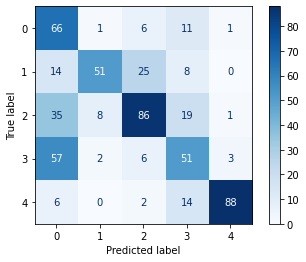

In [265]:
target_names = ['0', '1', '2', '3','4']
labels_names = [0,1,2,3,4]
print(classification_report(correct_labels, predicted_labels,labels=labels_names, target_names=target_names))
cm = confusion_matrix(correct_labels, predicted_labels,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()